In [16]:
#!pip install transformers
#!pip install datasets
#!pip install evaluate

import transformers
from transformers import AutoTokenizer
from transformers import TrainingArguments, Trainer
from transformers import AutoModelForSequenceClassification
import pandas as pd
import numpy as np
import torch
import json

In [17]:
with open('bert_config.json') as json_file:
    classifier_settings = json.load(json_file)

In [18]:
df_train = pd.read_csv(classifier_settings["train_dataset"])
df_test = pd.read_csv(classifier_settings["test_dataset"])

X = list(df_train["text"])
X_test = list(df_test["text"])
Y = list(df_train["label"])
Y_test = list(df_test["label"])

In [19]:
tokenizer: transformers.models.bert.tokenization_bert_fast.BertTokenizerFast = AutoTokenizer.from_pretrained("bert-base-german-cased")

X_train_tokenized = tokenizer(X, padding=True, truncation=True)
X_test_tokenized = tokenizer(X_test, padding=True, truncation=True)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-german-cased/snapshots/702774c02b32a4f360d5fea60ab034d64bf0141c/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-german-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.25.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30000
}

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--bert-base-german-cased/snapshots/702774c02b32a4f360d5fea60ab034d64bf0141c/vocab.txt
loading file tokenizer.json from ca

In [20]:
# Create torch dataset
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])


train_dataset = Dataset(X_train_tokenized, Y)
val_dataset = Dataset(X_test_tokenized, Y_test)

In [21]:
model = AutoModelForSequenceClassification.from_pretrained("bert-base-german-cased", num_labels=classifier_settings["num_labels"])
model = model.to('cuda')

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-german-cased/snapshots/702774c02b32a4f360d5fea60ab034d64bf0141c/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-german-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.25.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30000
}

loading weights file pytorch_model.bin 

In [22]:
from datasets import load_metric
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

def compute_metrics(p):
    print(type(p))
    pred, labels = p
    pred = np.argmax(pred, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred, average='macro')
    precision = precision_score(y_true=labels, y_pred=pred, average='macro')
    f1 = f1_score(y_true=labels, y_pred=pred, average='macro')

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

In [23]:
import sys
torch.cuda.empty_cache()
args = TrainingArguments(
    output_dir="output",
    num_train_epochs=classifier_settings["epochs"],
    per_device_train_batch_size=classifier_settings["batch_size"],
    evaluation_strategy="epoch",
    learning_rate=classifier_settings["learning_rate"]
)

class CustomTrainer(Trainer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")

        # compute custom loss (suppose 3 labels with different weights)
        loss_fct = torch.nn.CrossEntropyLoss(weight=torch.tensor(classifier_settings["weights"]).to('cuda'))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

trainer = CustomTrainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)
trainer.train()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 17440
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1090
  Number of trainable parameters = 109083651


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: ignored

In [ ]:
trainer.save_model(classifier_settings["model_name"])

In [ ]:
### Testing model ###
model_2 = AutoModelForSequenceClassification.from_pretrained(classifier_settings["model_name"])
model_2.to('cuda')

In [13]:
predictions_train = trainer.predict(train_dataset)
predictions_test = trainer.predict(val_dataset)
predictions_train = predictions_train[0].argmax(axis=1)
predictions_test = predictions_test[0].argmax(axis=1)

***** Running Prediction *****
  Num examples = 17440
  Batch size = 8


<class 'transformers.trainer_utils.EvalPrediction'>


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
***** Running Prediction *****
  Num examples = 5814
  Batch size = 8


<class 'transformers.trainer_utils.EvalPrediction'>


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


REPORT TRAIN
              precision    recall  f1-score   support

    positive     0.8540    1.0000    0.9213     14894
     neutral     0.0000    0.0000    0.0000       891
    negative     0.0000    0.0000    0.0000      1655

    accuracy                         0.8540     17440
   macro avg     0.2847    0.3333    0.3071     17440
weighted avg     0.7293    0.8540    0.7868     17440



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[]

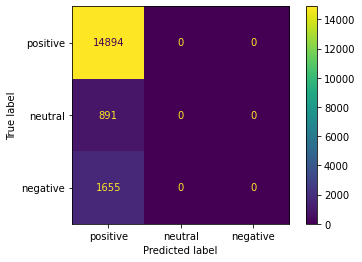

In [14]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt


names = ["positive", "neutral", "negative"]

print("REPORT TRAIN")
print(classification_report(Y, predictions_train, target_names=names, digits=4))
matrix = confusion_matrix(Y, predictions_train)

disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=names)
disp.plot()
plt.plot()

REPORT TEST
              precision    recall  f1-score   support

    positive     0.8553    1.0000    0.9220      4973
     neutral     0.0000    0.0000    0.0000       290
    negative     0.0000    0.0000    0.0000       551

    accuracy                         0.8553      5814
   macro avg     0.2851    0.3333    0.3073      5814
weighted avg     0.7316    0.8553    0.7887      5814



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[]

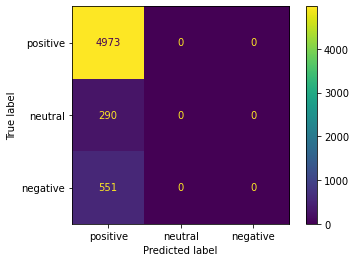

In [15]:
print("REPORT TEST")
print(classification_report(Y_test, predictions_test, target_names=names, digits=4))
matrix = confusion_matrix(Y_test, predictions_test)

disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=names)
disp.plot()
plt.plot()